In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import yfinance as yf

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [56]:
%%time
df = yf.download('^GSPC', start='2010-01-01')
df['ret'] = df.Close.pct_change()

[*********************100%***********************]  1 of 1 completed
CPU times: user 104 ms, sys: 12.9 ms, total: 117 ms
Wall time: 630 ms


In [4]:
def lagit(df, lags):
    for i in range(1, lags+1):
        df['lag_'+str(i)] = df.ret.shift(i)
    return ['lag_'+str(i) for i in range(1, lags+1)]

In [5]:
lagit(df, 2)

['lag_1', 'lag_2']

In [7]:
df['direction'] = np.where(df.ret > 0, 1, 0)

In [17]:
df.direction.value_counts()

1    1797
0    1518
Name: direction, dtype: int64

In [8]:
features = lagit(df, 3)
df.dropna(inplace=True)

In [14]:
X = df[features] #independent
y = df.direction #dependent

In [15]:
model = LogisticRegression(class_weight = 'balanced')

In [16]:
model.fit(X, y)

LogisticRegression(class_weight='balanced')

In [17]:
df['prediction_LR'] = model.predict(X)

In [18]:
df['strat'] = df['prediction_LR']*df['ret']

<AxesSubplot:xlabel='Date'>

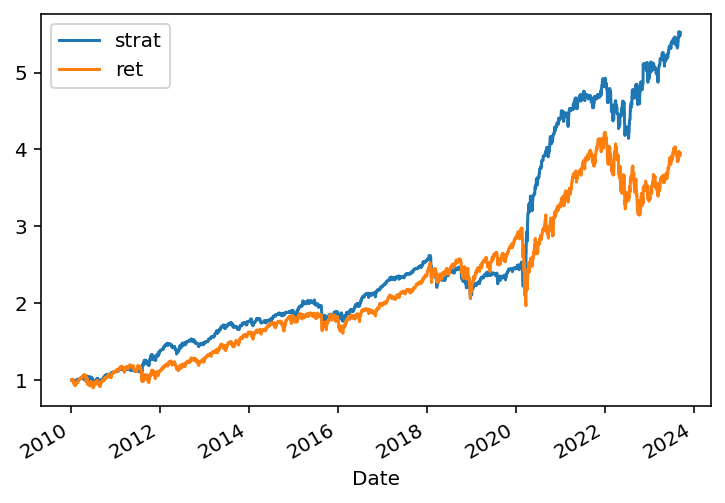

In [37]:
%config InlineBackend.figure_format='retina'
(1+df[['strat', 'ret']]).cumprod().plot()

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [40]:
X_train

,lag_1,lag_2,lag_3
Date,,,
2010-01-07,0.000546,0.003116,0.016043
2010-01-08,0.004001,0.000546,0.003116
2010-01-11,0.002882,0.004001,0.000546
2010-01-12,0.001747,0.002882,0.004001
2010-01-13,-0.009381,0.001747,0.002882
...,...,...,...
2019-07-29,0.007388,-0.005262,0.004688
2019-07-30,-0.001616,0.007388,-0.005262
2019-07-31,-0.002579,-0.001616,0.007388


In [41]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [42]:
X_test['prediction_LR'] = model.predict(X_test)
X_test['ret'] = df.ret[X_test.index[0]: ]
X_test['strat'] = X_test.prediction_LR * X_test.ret

<ipython-input-42-a60ab733ccc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prediction_LR'] = model.predict(X_test)
<ipython-input-42-a60ab733ccc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ret'] = df.ret[X_test.index[0]: ]
<ipython-input-42-a60ab733ccc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [43]:
X_test

,lag_1,lag_2,lag_3,prediction_LR,ret,strat
Date,,,,,,
2019-08-05,-0.007283,-0.008999,-0.010886,1,-0.029778,-0.029778
2019-08-06,-0.029778,-0.007283,-0.008999,1,0.013017,0.013017
2019-08-07,0.013017,-0.029778,-0.007283,0,0.000767,0.000000
2019-08-08,0.000767,0.013017,-0.029778,1,0.018762,0.018762
2019-08-09,0.018762,0.000767,0.013017,0,-0.006617,-0.000000
...,...,...,...,...,...,...
2023-09-05,0.001799,-0.001597,0.003833,0,-0.004194,-0.000000
2023-09-06,-0.004194,0.001799,-0.001597,1,-0.006972,-0.006972
2023-09-07,-0.006972,-0.004194,0.001799,1,-0.003211,-0.003211


<AxesSubplot:xlabel='Date'>

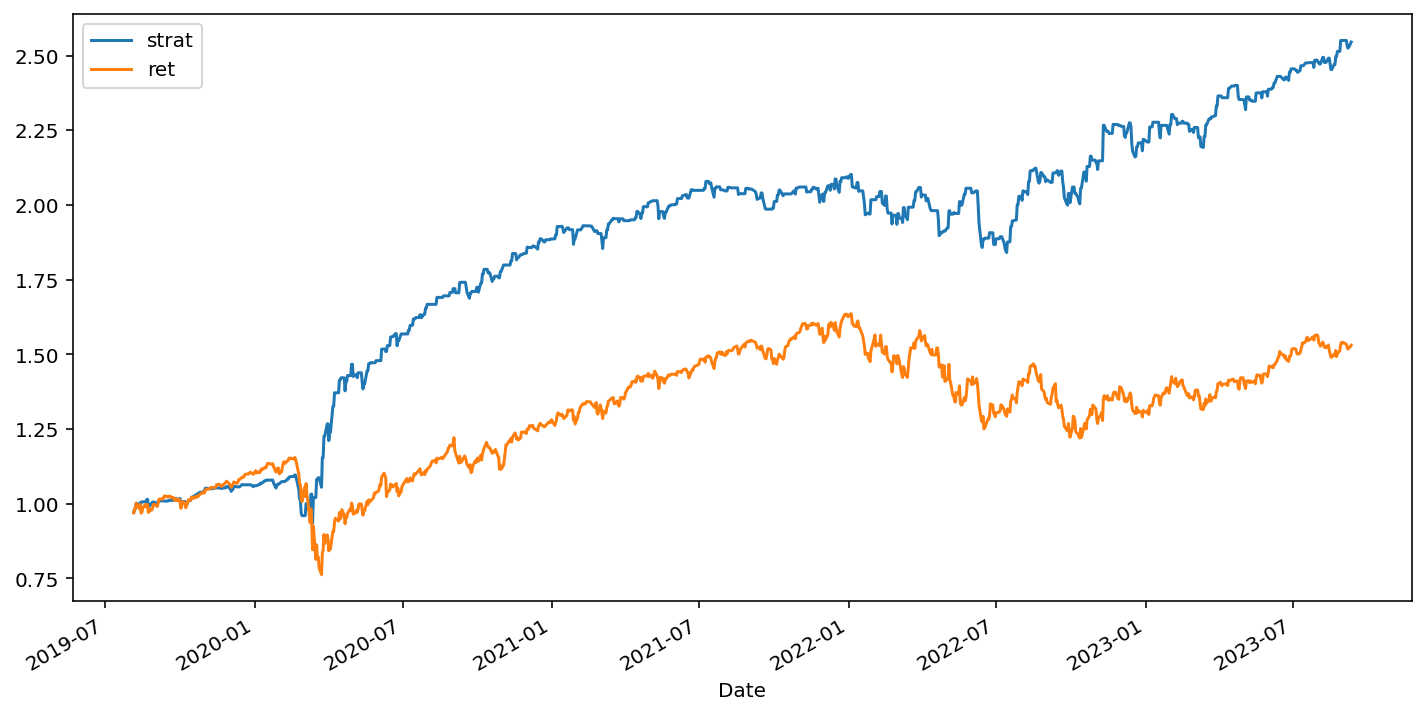

In [47]:
(X_test[['strat', 'ret']]+1).cumprod().plot(figsize=(12,6))

## Test with Nepse index

In [108]:
%%time
%config InlineBackend.figure_format = 'retina'
new_df = pd.read_excel('/Users/prajwal/Desktop/nepse/nepse_vs_sp500 (updated).xlsx')
new_df = new_df.set_index(new_df.Date)
nepse = pd.DataFrame(new_df.NEPSE)

CPU times: user 1.08 s, sys: 13.3 ms, total: 1.1 s
Wall time: 1.15 s


In [109]:
# calculating daily returns and lag features
nepse['ret'] = nepse.NEPSE.pct_change()
lagit(nepse, 2)

['lag_1', 'lag_2']

In [110]:
nepse['direction'] = np.where(nepse.ret > 0, 1, 0)
nepse.direction.value_counts()

0    3372
1    2059
Name: direction, dtype: int64

In [111]:
nep_features = lagit(nepse, 3)
nepse.dropna(inplace=True)

In [112]:
X = nepse[features]
y = nepse.direction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [113]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [114]:
X_test['prediction_LR'] = model.predict(X_test)
X_test['ret'] = nepse.ret[X_test.index[0]: ]
X_test['strat'] = X_test.prediction_LR * X_test.ret

<ipython-input-114-ceb90988e2f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prediction_LR'] = model.predict(X_test)
<ipython-input-114-ceb90988e2f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ret'] = nepse.ret[X_test.index[0]: ]
<ipython-input-114-ceb90988e2f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

<AxesSubplot:xlabel='Date'>

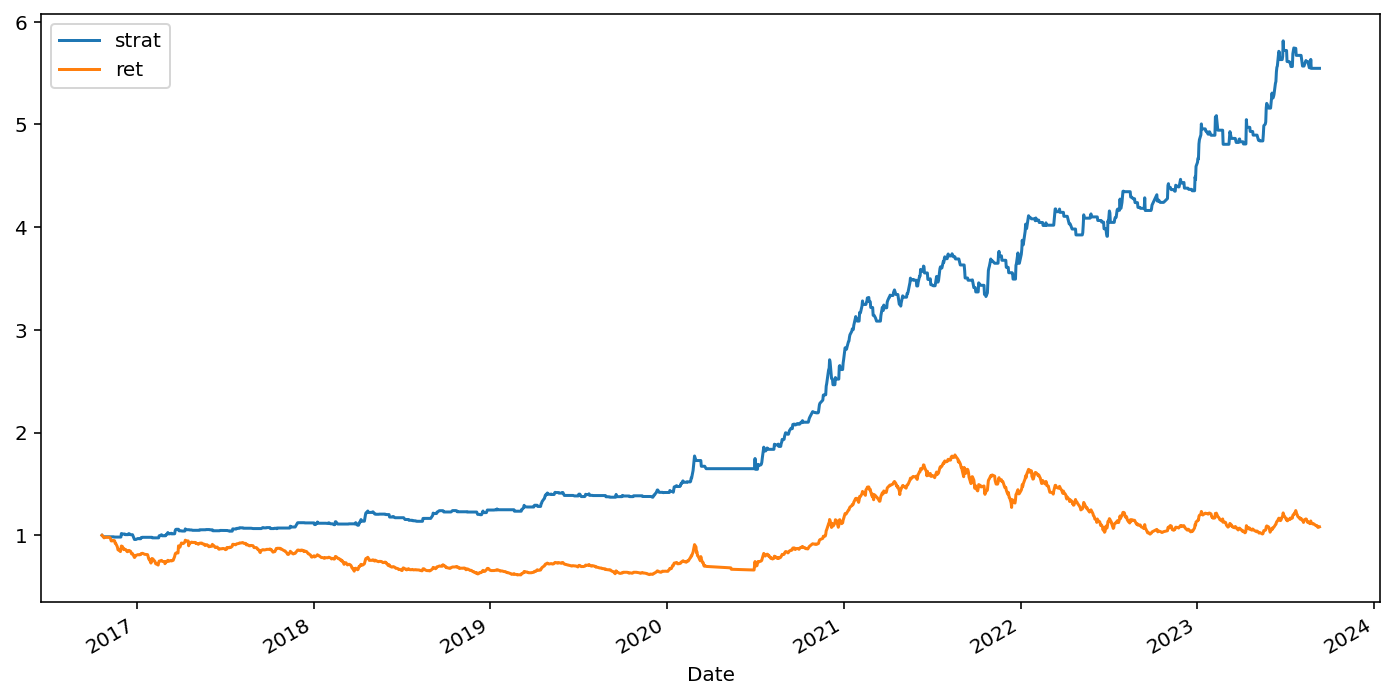

In [116]:
# Plot strategy vs bench
(X_test[['strat', 'ret']]+1).cumprod().plot(figsize=(12,6))